# Imports

In [20]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 15})

from sklearn.cluster import MiniBatchKMeans
from prince import PCA
from sklearn.manifold import TSNE

from helper_functions import variables_amount_deviation

# Data loading, preprocessing and feature engineering

In [3]:
# df = pd.read_csv('data/sim0.csv', delimiter=';', low_memory=False)
df = pd.read_csv('data/sim1.csv', delimiter=';', low_memory=False)
# df = pd.read_csv('data/sim3.csv', delimiter=';', low_memory=False)
# df = pd.read_csv('data/sim4.csv', delimiter=';', low_memory=False)
# df = pd.read_csv('data/sim5.csv', delimiter=';', low_memory=False)

# Strip hour since all are the same
df['date'] = pd.to_datetime(df.date).dt.date

# Drop columns with unique values
df.drop(columns=['currency', 'location'], inplace=True)

df.head()

,account_from,account_to,sender,receiver,amount,channel,date,flag,transaction_type,transaction_id
0,Account 113,Account 115,Fraudulent_businesses 4,Fraudulent_businesses 6,8774.32,Paym,2021-01-01,transaction,2.2,35655
1,Account 113,Account 115,Fraudulent_businesses 4,Fraudulent_businesses 6,56547.95,LINK,2021-01-01,transaction,2.2,35656
2,Account 113,Account 115,Fraudulent_businesses 4,Fraudulent_businesses 6,17.10,C&CCC,2021-01-01,transaction,0.1,35657
3,Account 113,Account 184,Fraudulent_businesses 4,Individuals 65,2000.00,CASH,2021-01-01,fraud,bribe,35658
4,Account 124,Account 170,Fraudulent_individuals 5,Individuals 51,91.15,FPS,2021-01-01,transaction,0.2,35659


# Feature Engineering

In [4]:
# Add type of transaction markers (B2B-P2P-B2P-P2B)

# Create markers
p2p_marker = (df.sender.str.lower().str.contains('individual') & 
              df.receiver.str.lower().str.contains('individual'))
p2b_marker = (df.sender.str.lower().str.contains('individual') & 
              df.receiver.str.lower().str.contains('business'))
b2b_marker = (df.sender.str.lower().str.contains('business') & 
              df.receiver.str.lower().str.contains('business'))
b2p_marker = (df.sender.str.lower().str.contains('business') & 
              df.receiver.str.lower().str.contains('individual'))

# Create Series object and add it to dataframe
transaction_mode = pd.Series(['']*df.shape[0])
transaction_mode[p2p_marker] = 'P2P'
transaction_mode[p2b_marker] = 'P2B'
transaction_mode[b2b_marker] = 'B2B'
transaction_mode[b2p_marker] = 'B2P'
df['transaction_mode'] = transaction_mode

# Add Sender and Receiver Marker
df['sender_type'] = df.transaction_mode.astype(str).str[0]
df['receiver_type'] = df.transaction_mode.astype(str).str[2]

# Manipulate date 
df['day_of_week'] = pd.to_datetime(df.date).dt.dayofweek
df['month'] = pd.to_datetime(df.date).dt.month
df.drop(columns=['date'], inplace=True)

df.head()

,account_from,account_to,sender,receiver,amount,channel,flag,transaction_type,transaction_id,transaction_mode,sender_type,receiver_type,day_of_week,month
0,Account 113,Account 115,Fraudulent_businesses 4,Fraudulent_businesses 6,8774.32,Paym,transaction,2.2,35655,B2B,B,B,4,1
1,Account 113,Account 115,Fraudulent_businesses 4,Fraudulent_businesses 6,56547.95,LINK,transaction,2.2,35656,B2B,B,B,4,1
2,Account 113,Account 115,Fraudulent_businesses 4,Fraudulent_businesses 6,17.10,C&CCC,transaction,0.1,35657,B2B,B,B,4,1
3,Account 113,Account 184,Fraudulent_businesses 4,Individuals 65,2000.00,CASH,fraud,bribe,35658,B2P,B,P,4,1
4,Account 124,Account 170,Fraudulent_individuals 5,Individuals 51,91.15,FPS,transaction,0.2,35659,P2P,P,P,4,1


In [6]:
# Get the scaled monthly median deviation per transaction
df = variables_amount_deviation(df, ['month'], ['sender_monthly', 'receiver_monthly'])
df.head()

,account_from,account_to,sender,receiver,amount,channel,flag,transaction_type,transaction_id,transaction_mode,sender_type,receiver_type,day_of_week,month,sender_monthly,receiver_monthly
0,Account 4,Account 6,Businesses 4,Businesses 6,8774.32,Paym,transaction,2.2,0,B2B,B,B,4,1,-13.855582,-34.791356
1,Account 4,Account 6,Businesses 4,Businesses 6,56547.95,LINK,transaction,2.2,1,B2B,B,B,4,1,-96.940697,-229.986936
2,Account 4,Account 6,Businesses 4,Businesses 6,17.10,C&CCC,transaction,0.1,2,B2B,B,B,4,1,1.374465,0.989275
3,Account 15,Account 61,Fraudulent_individuals 5,Individuals 51,60.63,FPS,transaction,0.2,3,P2P,P,P,4,1,-1.065967,-0.778006
4,Account 15,Account 61,Fraudulent_individuals 5,Individuals 51,33.47,C&CCC,transaction,0.2,4,P2P,P,P,4,1,0.085307,0.236184


In [6]:
# Get indicators of sender and receiver for both the deviation of the transaction
# According to certain groups

df = variables_amount_deviation(df, ['month'], ['sender_monthly', 'receiver_monthly'])
df = variables_amount_deviation(df, ['channel'], ['sender_medium', 'receiver_medium'])
df = variables_amount_deviation(df, ['account_from'], ['sender_account_from', 'receiver_account_from'])
df = variables_amount_deviation(df, ['account_to'], ['sender_account_to', 'receiver_account_to'])
df = variables_amount_deviation(df, ['channel', 'month'], ['sender_medium_month', 'receiver_medium_month'])
df = variables_amount_deviation(df, ['month', 'day_of_week'], ['sender_month_dayofweek', 'receiver_month_dayofweek'])
df = variables_amount_deviation(df, ['channel', 'day_of_week'], ['sender_medium_dayofweek', 'receiver_medium_dayofweek'])
df = variables_amount_deviation(df, ['account_from', 'channel'], ['sender_account_from_medium', 'receiver_account_from_medium'])
df = variables_amount_deviation(df, ['account_from', 'month'], ['sender_account_from_month', 'receiver_account_from_month'])
df = variables_amount_deviation(df, ['account_from', 'day_of_week'], ['sender_account_from_day_of_week', 
                                                                      'receiver_account_from_day_of_week'])
df = variables_amount_deviation(df, ['account_to', 'channel'], ['sender_fieldo_medium', 'receiver_fieldo_medium'])
df = variables_amount_deviation(df, ['account_to', 'month'], ['sender_fieldo_month', 'receiver_fieldo_month'])
df = variables_amount_deviation(df, ['account_to', 'day_of_week'], ['sender_fieldo_day_of_week', 'receiver_fieldo_day_of_week'])
df = variables_amount_deviation(df, ['channel', 'month', 'day_of_week'], ['sender_medium_month_dayofweek',
                                                                         'receiver_medium_month_dayofweek'])
df = variables_amount_deviation(df, ['account_from', 'month', 'channel'], ['sender_account_from_month_medium', 
                                                                          'receiver_account_from_month_medium'])
df = variables_amount_deviation(df, ['account_from', 'month','day_of_week'], ['sender_account_from_month_day_of_week', 
                                                                              'receiver_account_from_month_day_of_week'])
df = variables_amount_deviation(df, ['account_from', 'channel', 'day_of_week'], ['sender_account_from_medium_day_of_week', 
                                                                                'receiver_account_from_medium_day_of_week'])
df = variables_amount_deviation(df, ['account_from', 'month', 'channel', 'day_of_week'], ['sender_account_from_medium_day_of_week_month', 
                                                                                         'sender_account_from_medium_day_of_week_month'])
df = variables_amount_deviation(df, ['account_to', 'month', 'channel'], ['sender_account_to_month_medium', 
                                                                    'receiver_account_to_month_medium'])
df = variables_amount_deviation(df, ['account_to', 'month','day_of_week'], ['sender_account_to_month_day_of_week', 
                                                                        'receiver_account_to_month_day_of_week'])
df = variables_amount_deviation(df, ['account_to', 'channel', 'day_of_week'], ['sender_fieldo_medium_day_of_week', 
                                                                          'receiver_fieldo_medium_day_of_week'])
df = variables_amount_deviation(df, ['account_to', 'month', 'channel', 'day_of_week'], ['sender_account_to_medium_day_of_week_month', 
                                                                                   'sender_account_to_medium_day_of_week_month'])

df.head()

,account_from,account_to,sender,receiver,amount,channel,flag,transaction_type,transaction_id,transaction_mode,...,sender_account_from_medium_day_of_week,receiver_account_from_medium_day_of_week,sender_account_from_medium_day_of_week_month,sender_account_to_month_medium,receiver_account_to_month_medium,sender_account_to_month_day_of_week,receiver_account_to_month_day_of_week,sender_fieldo_medium_day_of_week,receiver_fieldo_medium_day_of_week,sender_account_to_medium_day_of_week_month
0,Account 113,Account 115,Fraudulent_businesses 4,Fraudulent_businesses 6,8774.32,Paym,transaction,2.2,35655,B2B,...,-9.625227,-11.272045,-10.823727,-11.085894,-12.066057,-15.601798,-13.480691,-16.894108,-12.311141,-10.531192
1,Account 113,Account 115,Fraudulent_businesses 4,Fraudulent_businesses 6,56547.95,LINK,transaction,2.2,35656,B2B,...,-74.604424,-153.474034,-1.000000,-61.303750,-63.794844,-107.852925,-94.432365,-152.949409,-150.311716,-226.123005
2,Account 113,Account 115,Fraudulent_businesses 4,Fraudulent_businesses 6,17.10,C&CCC,transaction,0.1,35657,B2B,...,1.294991,1.201411,1.309633,1.540150,1.249522,1.308439,1.358282,1.462267,1.257397,1.310560
3,Account 113,Account 184,Fraudulent_businesses 4,Individuals 65,2000.00,CASH,fraud,bribe,35658,B2P,...,-365.873062,-365.873062,-197.376050,-197.376050,-197.376050,-197.376050,-58.702785,-365.873062,-365.873062,-197.376050
4,Account 124,Account 170,Fraudulent_individuals 5,Individuals 51,91.15,FPS,transaction,0.2,35659,P2P,...,-7.481609,-7.481609,-1.000000,-2.393939,-2.188634,-0.996209,-2.010216,-6.800211,-3.779671,-1.000000


In [9]:
# Field A Scaling

# Segment types of senders
df_p = df[p2p_marker | p2b_marker]
df_b = df[b2p_marker | b2b_marker]

# Get Median 
median_p = np.median(df_p.amount)
median_b = np.median(df_b.amount)

# Median Deviation 
median_desviation_p = df_p.amount.sub(median_p)
median_desviation_b = df_b.amount.sub(median_b)

# Median Absolute Deviation
abs_median_desviation_p = np.median(median_desviation_p.abs())
abs_median_desviation_b = np.median(median_desviation_b.abs())

# Scaling 
df_p_scaled = median_desviation_p/abs_median_desviation_p
df_b_scaled = median_desviation_b/abs_median_desviation_b

# Assign values
df.loc[(p2p_marker | p2b_marker), 'amount'] = df_p_scaled
df.loc[(b2p_marker | b2b_marker), 'amount'] = df_b_scaled

df = df.replace([np.inf, -np.inf, np.nan], 0)
df.head()

,account_from,account_to,sender,receiver,amount,channel,flag,transaction_type,transaction_id,transaction_mode,...,sender_account_from_medium_day_of_week,receiver_account_from_medium_day_of_week,sender_account_from_medium_day_of_week_month,sender_account_to_month_medium,receiver_account_to_month_medium,sender_account_to_month_day_of_week,receiver_account_to_month_day_of_week,sender_fieldo_medium_day_of_week,receiver_fieldo_medium_day_of_week,sender_account_to_medium_day_of_week_month
0,Account 113,Account 115,Fraudulent_businesses 4,Fraudulent_businesses 6,15.353341,Paym,transaction,2.2,35655,B2B,...,-9.625227,-11.272045,-10.823727,-11.085894,-12.066057,-15.601798,-13.480691,-16.894108,-12.311141,-10.531192
1,Account 113,Account 115,Fraudulent_businesses 4,Fraudulent_businesses 6,106.878088,LINK,transaction,2.2,35656,B2B,...,-74.604424,-153.474034,-1.000000,-61.303750,-63.794844,-107.852925,-94.432365,-152.949409,-150.311716,-226.123005
2,Account 113,Account 115,Fraudulent_businesses 4,Fraudulent_businesses 6,-1.423746,C&CCC,transaction,0.1,35657,B2B,...,1.294991,1.201411,1.309633,1.540150,1.249522,1.308439,1.358282,1.462267,1.257397,1.310560
3,Account 113,Account 184,Fraudulent_businesses 4,Individuals 65,2.375095,CASH,fraud,bribe,35658,B2P,...,-365.873062,-365.873062,-197.376050,-197.376050,-197.376050,-197.376050,-58.702785,-365.873062,-365.873062,-197.376050
4,Account 124,Account 170,Fraudulent_individuals 5,Individuals 51,2.821119,FPS,transaction,0.2,35659,P2P,...,-7.481609,-7.481609,-1.000000,-2.393939,-2.188634,-0.996209,-2.010216,-6.800211,-3.779671,-1.000000


In [10]:
df.describe()

,amount,transaction_id,day_of_week,month,sender_monthly,receiver_monthly,sender_medium,receiver_medium,sender_account_from,receiver_account_from,...,sender_account_from_medium_day_of_week,receiver_account_from_medium_day_of_week,sender_account_from_medium_day_of_week_month,sender_account_to_month_medium,receiver_account_to_month_medium,sender_account_to_month_day_of_week,receiver_account_to_month_day_of_week,sender_fieldo_medium_day_of_week,receiver_fieldo_medium_day_of_week,sender_account_to_medium_day_of_week_month
count,36098.000000,36098.000000,36098.000000,36098.000000,36098.000000,36098.000000,36098.000000,36098.000000,36098.000000,36098.000000,...,36098.000000,36098.000000,36098.000000,36098.000000,36098.000000,36098.000000,36098.000000,36098.000000,36098.000000,36098.000000
mean,6.568124,53703.500000,3.004765,6.803867,-5.881066,-12.958601,-6.762256,-14.905236,-1.791281,-2.991338,...,-2.143731,-4.316495,-2.273524,-3.083298,-19.794261,-3.115067,-8.485355,-5.891968,-8.793945,-16.491366
std,169.430702,10420.739345,1.978324,3.334329,148.647120,159.692077,167.868385,176.998019,30.626893,97.657242,...,42.669460,374.895278,78.289649,98.636275,2638.962560,105.120427,631.202466,397.631455,412.411059,2634.692906
min,-1.571842,35655.000000,0.000000,1.000000,-5058.094867,-5371.262523,-5890.501811,-5510.441433,-2247.729335,-12582.803686,...,-3884.000000,-70662.000000,-9191.000000,-9963.906977,-499949.583333,-14225.139301,-115278.278846,-70662.000000,-70662.000000,-499949.583333
25%,-0.828215,44679.250000,1.000000,4.000000,-1.226706,-1.665496,-1.210721,-1.639965,-1.238729,-1.264704,...,-1.150931,-1.057067,-0.848395,-1.000000,-1.064814,-1.000000,-1.022644,-1.142586,-1.192741,-1.000000
50%,0.000000,53703.500000,3.000000,7.000000,0.005332,-0.136637,0.003850,-0.128534,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.246384,62727.750000,5.000000,10.000000,0.871647,0.762781,0.850277,0.818105,0.861185,0.934831,...,0.954719,0.969038,0.706944,0.978789,0.965199,0.980297,0.965109,0.957044,0.935662,0.940381
max,5784.347155,71752.000000,6.000000,12.000000,1.854804,1.724593,2.977795,2.977795,2.102287,7.427332,...,1780.500000,1780.500000,1450.373016,1904.000000,1904.000000,1341.500000,1341.500000,100.809524,344.000000,14406.500000


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36098 entries, 0 to 36097
Data columns (total 56 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   account_from                                  36098 non-null  object 
 1   account_to                                    36098 non-null  object 
 2   sender                                        36098 non-null  object 
 3   receiver                                      36098 non-null  object 
 4   amount                                        36098 non-null  float64
 5   channel                                       36098 non-null  object 
 6   flag                                          36098 non-null  object 
 7   transaction_type                              36098 non-null  object 
 8   transaction_id                                36098 non-null  int64  
 9   transaction_mode                              36098 non-null 

# Clustering Testing

MiniBatchKMeans: Done


,account_from,account_to,sender,receiver,amount,channel,flag,transaction_type,transaction_id,transaction_mode,...,sender_account_from_medium_day_of_week,receiver_account_from_medium_day_of_week,sender_account_from_medium_day_of_week_month,sender_account_to_month_medium,receiver_account_to_month_medium,sender_account_to_month_day_of_week,receiver_account_to_month_day_of_week,sender_fieldo_medium_day_of_week,receiver_fieldo_medium_day_of_week,sender_account_to_medium_day_of_week_month
0,Account 113,Account 115,Fraudulent_businesses 4,Fraudulent_businesses 6,15.353341,Paym,transaction,2.2,35655,B2B,...,-9.625227,-11.272045,-10.823727,-11.085894,-12.066057,-15.601798,-13.480691,-16.894108,-12.311141,-10.531192
1,Account 113,Account 115,Fraudulent_businesses 4,Fraudulent_businesses 6,106.878088,LINK,transaction,2.2,35656,B2B,...,-74.604424,-153.474034,-1.000000,-61.303750,-63.794844,-107.852925,-94.432365,-152.949409,-150.311716,-226.123005
2,Account 113,Account 115,Fraudulent_businesses 4,Fraudulent_businesses 6,-1.423746,C&CCC,transaction,0.1,35657,B2B,...,1.294991,1.201411,1.309633,1.540150,1.249522,1.308439,1.358282,1.462267,1.257397,1.310560
3,Account 113,Account 184,Fraudulent_businesses 4,Individuals 65,2.375095,CASH,fraud,bribe,35658,B2P,...,-365.873062,-365.873062,-197.376050,-197.376050,-197.376050,-197.376050,-58.702785,-365.873062,-365.873062,-197.376050
4,Account 124,Account 170,Fraudulent_individuals 5,Individuals 51,2.821119,FPS,transaction,0.2,35659,P2P,...,-7.481609,-7.481609,-1.000000,-2.393939,-2.188634,-0.996209,-2.010216,-6.800211,-3.779671,-1.000000


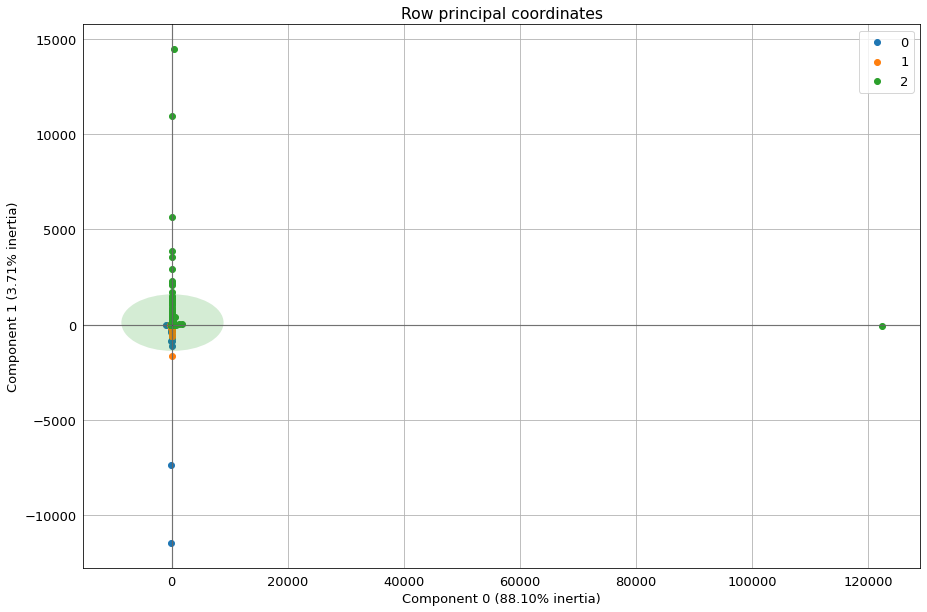

In [14]:
df_cluster = df.select_dtypes('float64')

df_cluster = df_cluster[df_cluster.amount < df_cluster.amount.quantile(0.90)]

# MiniBatchKMeans
mbk = MiniBatchKMeans(n_clusters=3, batch_size=2050)
mbk.fit(df_cluster)
labels = mbk.predict(df_cluster)
print('MiniBatchKMeans: Done')

pca_prince = PCA(n_components=2, n_iter=3, 
                 rescale_with_mean=False, rescale_with_std=False)

coordinates = pca_prince.fit_transform(df_cluster)
pca_prince.plot_row_coordinates(df_cluster, figsize=(15, 10), 
                          color_labels=labels)

df.head()

In [15]:
pca_prince.column_correlations(df_cluster).sort_values(by=[0], ascending=False)

,0,1
amount,0.006456,0.052572
sender_fieldo_month,0.000066,-0.035097
receiver_account_from_month_day_of_week,-0.000050,-0.005912
receiver_account_from_month,-0.000102,-0.016582
sender_account_from_month_day_of_week,-0.000147,-0.006317
sender_account_to_month_day_of_week,-0.000344,-0.007092
receiver_account_to_month_day_of_week,-0.000514,-0.008054
receiver_account_from_day_of_week,-0.000598,-0.008596
sender_account_to_medium_day_of_week_month,-0.001600,-0.900006
receiver_account_to_month_medium,-0.002123,-0.445664


In [16]:
# Get components and append it to dataframe
df['pca_first_component'] = coordinates[0]
df['pca_second_component'] = coordinates[1]

# Exploratory Data Analysis

## Check if all accounts are owned by only one Individual/Business

In [18]:
def check_shared_accounts(x):
    
    """
    Tells wether a vector contains more than one positive numbers or not.
    
    Args:
        x:vector of observations.
        
    Returns:
        Boolean
    """
    
    num_people = 0
    for xi in x:
        if xi > 0:
            num_people += 1
    
    return num_people > 1

# Create DataFrame with all accounts and owners
df_accounts = pd.DataFrame({'accounts': df.account_from.append(df.account_to),
                            'owners': df.sender.append(df.receiver)})
df_accounts = df_accounts.drop_duplicates()
occurrence = pd.crosstab(df_accounts.accounts, df_accounts.owners)

# Check for accounts with two owners
shared_accounts = occurrence.apply(lambda x: check_shared_accounts(x), axis=1)
print('Number of shared accounts: ',sum(shared_accounts))

# Check for owners with two accounts
multiple_account_owners = occurrence.apply(lambda x: check_shared_accounts(x), axis=0)
print('Number of multiple account owners: ',sum(multiple_account_owners))

# Show multiple account owner
print('Multiple Account Owner ID: ',occurrence.columns[multiple_account_owners])

Number of shared accounts:  0
Number of multiple account owners:  30
Multiple Account Owner ID:  Index(['Fraudulent_individuals 0', 'Fraudulent_individuals 1',
       'Fraudulent_individuals 10', 'Fraudulent_individuals 11',
       'Fraudulent_individuals 12', 'Fraudulent_individuals 13',
       'Fraudulent_individuals 14', 'Fraudulent_individuals 15',
       'Fraudulent_individuals 16', 'Fraudulent_individuals 17',
       'Fraudulent_individuals 18', 'Fraudulent_individuals 19',
       'Fraudulent_individuals 2', 'Fraudulent_individuals 20',
       'Fraudulent_individuals 21', 'Fraudulent_individuals 22',
       'Fraudulent_individuals 23', 'Fraudulent_individuals 24',
       'Fraudulent_individuals 25', 'Fraudulent_individuals 26',
       'Fraudulent_individuals 27', 'Fraudulent_individuals 28',
       'Fraudulent_individuals 29', 'Fraudulent_individuals 3',
       'Fraudulent_individuals 4', 'Fraudulent_individuals 5',
       'Fraudulent_individuals 6', 'Fraudulent_individuals 7',
 

## Check for transaction amount distribution

Text(0.5, 0, 'GBP')

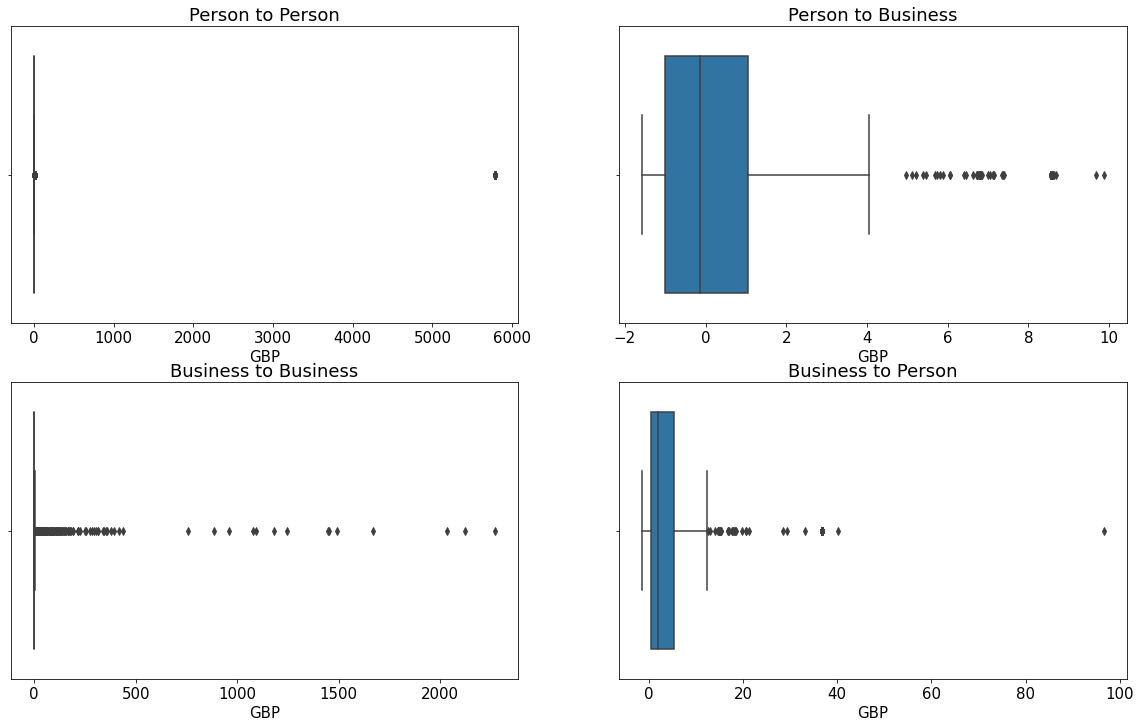

In [21]:
# Get ammounts for different transaction modes
p2p_transaction_ammount = df.amount[p2p_marker]
p2b_transaction_ammount = df.amount[p2b_marker]
b2b_transaction_ammount = df.amount[b2b_marker]
b2p_transaction_ammount = df.amount[b2p_marker]

# Build boxplots for each transaction mode
fig, ax = plt.subplots(2, 2, figsize=(20, 12))

p2p_boxplot = sns.boxplot(x=p2p_transaction_ammount, ax=ax[0,0])
ax[0, 0].set_title('Person to Person')
ax[0, 0].set_xlabel('GBP')

p2b_boxplot = sns.boxplot(x=p2b_transaction_ammount, ax=ax[0,1])
ax[0, 1].set_title('Person to Business')
ax[0, 1].set_xlabel('GBP')

b2b_boxplot = sns.boxplot(x=b2b_transaction_ammount, ax=ax[1,0])
ax[1, 0].set_title('Business to Business')
ax[1, 0].set_xlabel('GBP')

b2p_boxplot = sns.boxplot(x=b2p_transaction_ammount, ax=ax[1,1])
ax[1, 1].set_title('Business to Person')
ax[1, 1].set_xlabel('GBP')

### Strip Outliers to visualize better the data distributions

Text(0.5, 0, 'GBP')

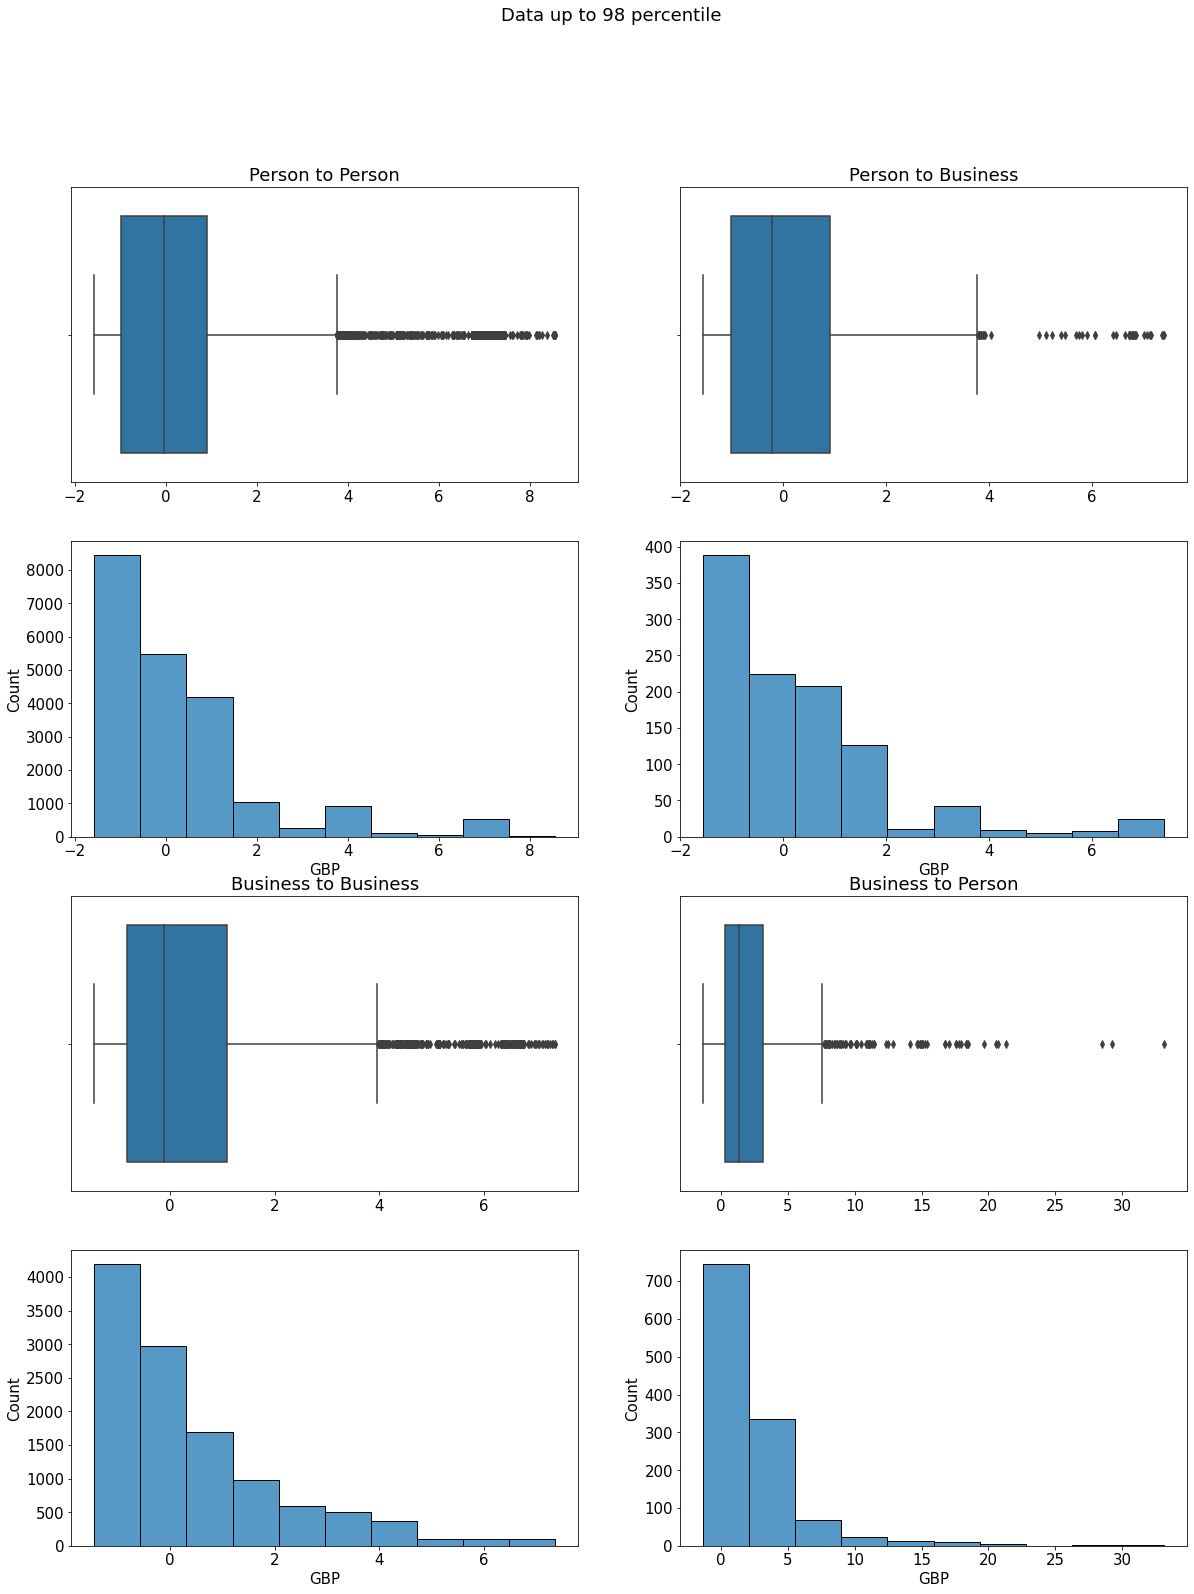

In [22]:
perc = 0.98

p2p_trans_stripped = p2p_transaction_ammount[p2p_transaction_ammount\
                                             < p2p_transaction_ammount.quantile(perc)]
p2b_trans_stripped = p2b_transaction_ammount[p2b_transaction_ammount\
                                             < p2b_transaction_ammount.quantile(perc)]
b2b_trans_stripped = b2b_transaction_ammount[b2b_transaction_ammount\
                                             < b2b_transaction_ammount.quantile(perc)]
b2p_trans_stripped = b2p_transaction_ammount[b2p_transaction_ammount\
                                             < b2p_transaction_ammount.quantile(perc)]

# Build boxplots for each transaction mode
fig, ax = plt.subplots(4, 2, figsize=(20, 25))

fig.suptitle(f'Data up to {int(perc*100)} percentile')

p2p_boxplot = sns.boxplot(x=p2p_trans_stripped, ax=ax[0,0])
p2p_hist = sns.histplot(p2p_trans_stripped, bins=10, ax=ax[1,0])
ax[0, 0].set_title('Person to Person')
ax[0, 0].set_xlabel('')
ax[1, 0].set_xlabel('GBP')

p2b_boxplot = sns.boxplot(x=p2b_trans_stripped, ax=ax[0,1])
p2b_hist = sns.histplot(p2b_trans_stripped, bins=10, ax=ax[1,1])
ax[0, 1].set_title('Person to Business')
ax[0, 1].set_xlabel('')
ax[1, 1].set_xlabel('GBP')

b2b_boxplot = sns.boxplot(x=b2b_trans_stripped, ax=ax[2,0])
b2b_hist = sns.histplot(b2b_trans_stripped, bins=10, ax=ax[3,0])
ax[2, 0].set_title('Business to Business')
ax[2, 0].set_xlabel('')
ax[3, 0].set_xlabel('GBP')

b2p_boxplot = sns.boxplot(x=b2p_trans_stripped, ax=ax[2,1])
b2p_hist = sns.histplot(b2p_trans_stripped, bins=10, ax=ax[3,1])
ax[2, 1].set_title('Business to Person')
ax[2, 1].set_xlabel('')
ax[3, 1].set_xlabel('GBP')

## More Variable Appearance

Text(0, 0.5, '')

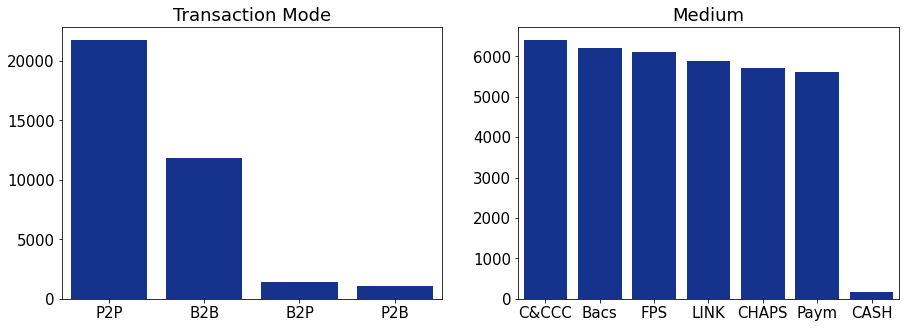

In [23]:
trans_mode_appearance = df.transaction_mode.value_counts().reset_index()
medium_appearance = df.channel.value_counts().reset_index()

# Plot
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

trans_bar = sns.barplot(data=trans_mode_appearance, x='index', 
                        y='transaction_mode', color='#0129A0', ax=ax[0])
ax[0].set_title('Transaction Mode')
ax[0].set_xlabel('')
ax[0].set_ylabel('')

medium_bar = sns.barplot(data=medium_appearance, x='index',
                        y='channel', color='#0129A0', ax=ax[1])
ax[1].set_title('Medium')
ax[1].set_xlabel('')
ax[1].set_ylabel('')

Text(0.5, 0.98, 'Transaction Mode Distribution across different Mediums')

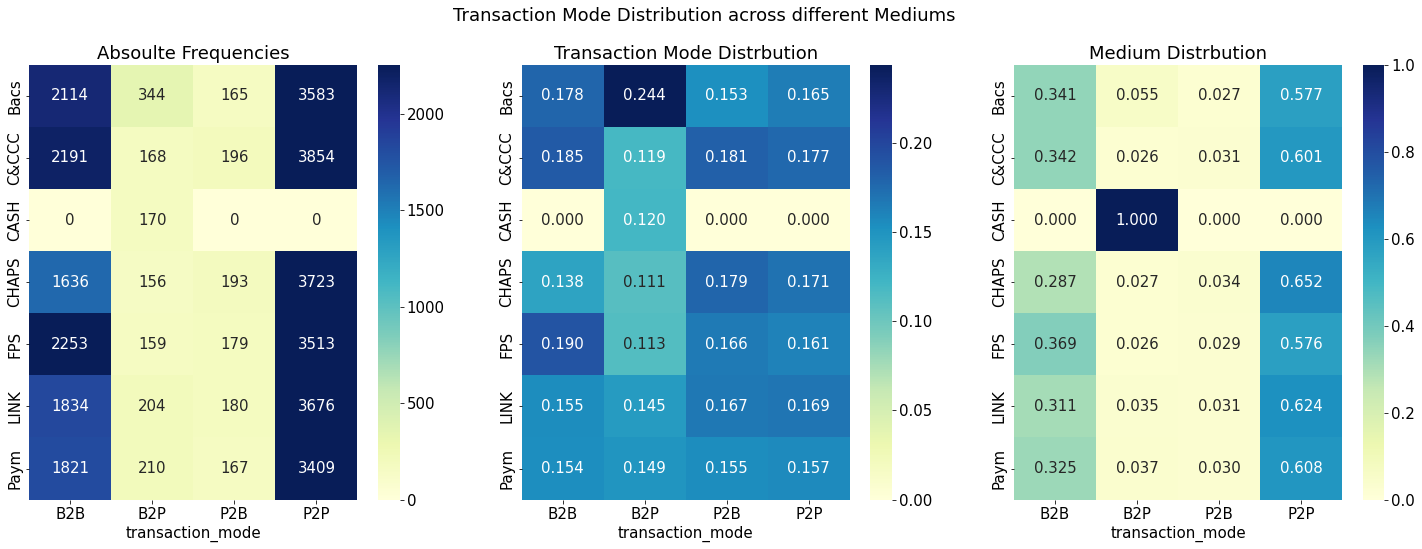

In [24]:
# Heatmap
fig, ax = plt.subplots(1, 3, figsize=(25,8))

fieldc_trans_mode = pd.crosstab(df.channel, df.transaction_mode)#, normalize='columns')

heatmap = sns.heatmap(fieldc_trans_mode, annot = True, fmt = 'd',  cmap="YlGnBu", 
                   vmin=0, vmax=fieldc_trans_mode['B2B'].max(), ax=ax[0])
ax[0].set_title('Absoulte Frequencies')
ax[0].set_ylabel('')

fieldc_trans_mode_col = pd.crosstab(df.channel, df.transaction_mode, normalize='columns')

heatmap = sns.heatmap(fieldc_trans_mode_col, annot = True, fmt = '.3f',  cmap="YlGnBu", 
                   vmin=0, vmax=fieldc_trans_mode_col['B2P'].max(), ax=ax[1])
ax[1].set_title('Transaction Mode Distrbution')
ax[1].set_ylabel('')

fieldc_trans_mode_ind = pd.crosstab(df.channel, df.transaction_mode, normalize='index')

heatmap = sns.heatmap(fieldc_trans_mode_ind, annot = True, fmt = '.3f',  cmap="YlGnBu", 
                   vmin=0, vmax=1, ax=ax[2])
ax[2].set_title('Medium Distrbution')
ax[2].set_ylabel('')

fig.suptitle('Transaction Mode Distribution across different Mediums')

Text(0.5, 0.98, 'Transaction Mode Distribution across different Days of the Week')

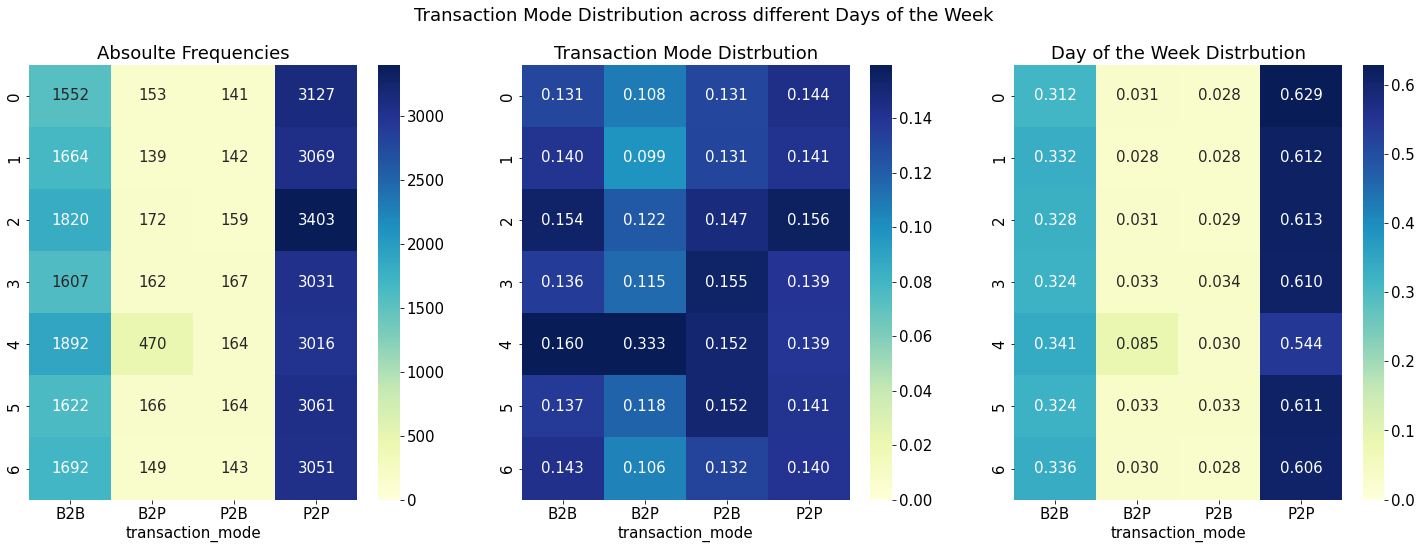

In [25]:
# Heatmap
fig, ax = plt.subplots(1, 3, figsize=(25,8))

trans_mode_day_of_week = pd.crosstab(df.day_of_week, df.transaction_mode)

heatmap = sns.heatmap(trans_mode_day_of_week, annot = True, fmt = 'd',  cmap="YlGnBu", 
                   vmin=0, vmax=trans_mode_day_of_week['P2P'].max(), ax=ax[0])
ax[0].set_title('Absoulte Frequencies')
ax[0].set_ylabel('')

trans_mode_day_of_week_col = pd.crosstab(df.day_of_week, df.transaction_mode, normalize='columns')

heatmap = sns.heatmap(trans_mode_day_of_week_col, annot = True, fmt = '.3f',  cmap="YlGnBu", 
                   vmin=0, vmax=trans_mode_day_of_week_col['B2B'].max(), ax=ax[1])
ax[1].set_title('Transaction Mode Distrbution')
ax[1].set_ylabel('')

trans_mode_day_of_week_ind = pd.crosstab(df.day_of_week, df.transaction_mode, normalize='index')

heatmap = sns.heatmap(trans_mode_day_of_week_ind, annot = True, fmt = '.3f',  cmap="YlGnBu", 
                   vmin=0, vmax=trans_mode_day_of_week_ind['P2P'].max(), ax=ax[2])
ax[2].set_title('Day of the Week Distrbution')
ax[2].set_ylabel('')

fig.suptitle('Transaction Mode Distribution across different Days of the Week')

Text(0.5, 0.98, 'Transaction Mode Distribution across different Months')

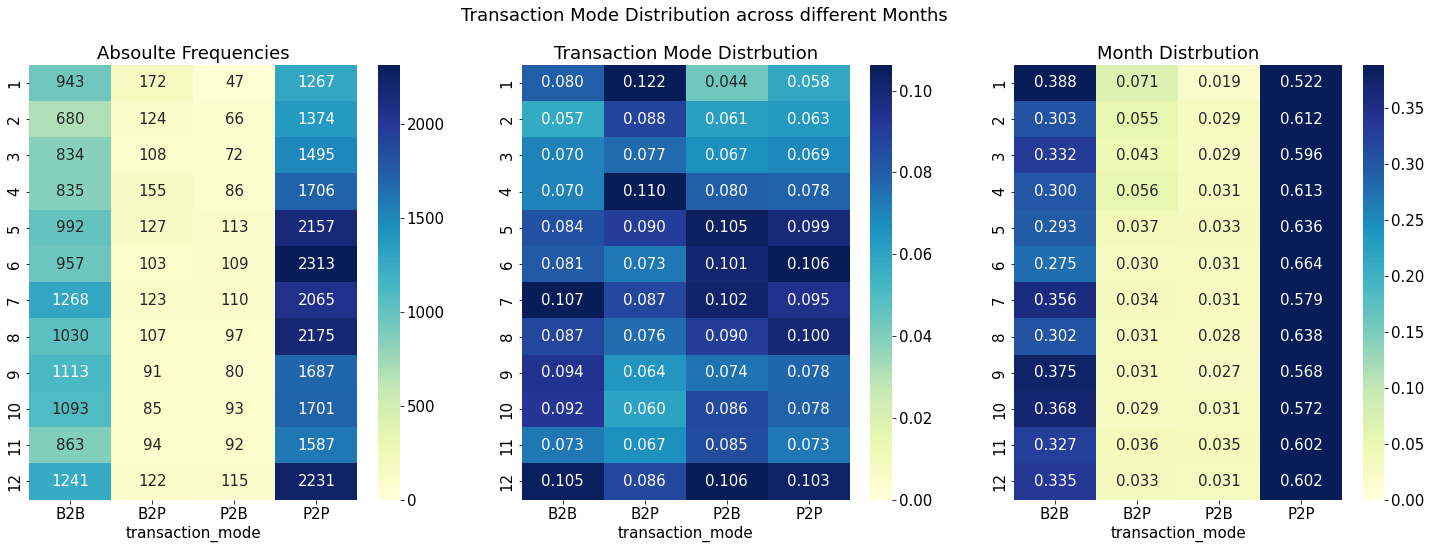

In [26]:
# Heatmap
fig, ax = plt.subplots(1, 3, figsize=(25,8))

trans_mode_month = pd.crosstab(df.month, df.transaction_mode)

heatmap = sns.heatmap(trans_mode_month, annot = True, fmt = 'd',  cmap="YlGnBu", 
                   vmin=0, vmax=trans_mode_month['P2P'].max(), ax=ax[0])
ax[0].set_title('Absoulte Frequencies')
ax[0].set_ylabel('')

trans_mode_month_col = pd.crosstab(df.month, df.transaction_mode, normalize='columns')

heatmap = sns.heatmap(trans_mode_month_col, annot = True, fmt = '.3f',  cmap="YlGnBu", 
                   vmin=0, vmax=trans_mode_month_col['P2P'].max(), ax=ax[1])
ax[1].set_title('Transaction Mode Distrbution')
ax[1].set_ylabel('')

trans_mode_month_ind = pd.crosstab(df.month, df.transaction_mode, normalize='index')

heatmap = sns.heatmap(trans_mode_month_ind, annot = True, fmt = '.3f',  cmap="YlGnBu", 
                   vmin=0, vmax=trans_mode_month_ind['B2B'].max(), ax=ax[2])
ax[2].set_title('Month Distrbution')
ax[2].set_ylabel('')

fig.suptitle('Transaction Mode Distribution across different Months')

# Clustering Notes

- It is necessary to scale the ammount variable because the algorithm failes to build 7 clusters or more.
- Due to the big difference in magnitude of transactions between Individuals and Businesses the observations will be scaled according to senders pertenence.

## Neighborhoods

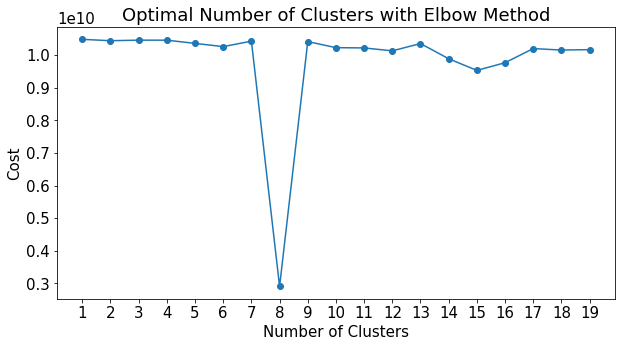

In [54]:
# Drop categorical variables
df_kmeans = df.select_dtypes('float64')

distortion = []
n_max = 20

for cluster in range(1, n_max):
    
    mbk = MiniBatchKMeans(n_clusters=cluster, batch_size=2050)
    mbk.fit(df_kmeans)
    distortion.append(mbk.inertia_)
    
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(range(1, n_max), distortion)
ax.scatter(range(1, n_max), distortion, marker='o')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Cost')
ax.set_title('Optimal Number of Clusters with Elbow Method')
ax.set_xticks(range(1, n_max))

In [ ]:
df_cluster = df_kmeans

df_cluster = df_cluster[df_cluster.amount < df_cluster.amount.quantile(0.90)]

# MiniBatchKMeans
mbk = MiniBatchKMeans(n_clusters=3, batch_size=2050)
mbk.fit(df_cluster)
labels = mbk.predict(df_cluster)
print('MiniBatchKMeans: Done')

pca_prince = PCA(n_components=2, n_iter=3, 
                 rescale_with_mean=False, rescale_with_std=False)

coordinates = pca_prince.fit_transform(df_cluster)
pca_prince.plot_row_coordinates(df_cluster, figsize=(15, 10), 
                          color_labels=labels)

df.head()

In [ ]:
# Select coordinates of outliers
indexes = coordinates[(coordinates[1] > 5) & (coordinates[0] < 11)].index.tolist()

df.iloc[indexes,:]

In [ ]:
df.transaction_type.value_counts()

## KPrototype Clustering 

In [ ]:
df_clustering = df[['amount', 'channel', 'sender_type', 'receiver_type', 'day_of_week', 'mont']]

In [ ]:
# Obtain categorical variables index and convert df to numpy
catColumnsPos = [df_clustering.columns.get_loc(col)\
                 for col in list(df_clustering.select_dtypes('object').columns)]
np_clustering = df_clustering_sample.to_numpy()

In [ ]:
# Choose optimal K using Elbow method
cost = []
for cluster in range(1, 21):
    kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang')
    kprototype.fit_predict(np_clustering, categorical = catColumnsPos)
    cost.append(kprototype.cost_)
    print('Cluster initiation: {}'.format(cluster))

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(range(1, 9), cost)
ax.scatter(range(1, 9), cost, marker='o')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Cost')
ax.set_title('Optimal Number of Clusters with Elbow Method')
ax.set_xticks(range(1, 9))

In [ ]:
cost

In [ ]:
# Test prediction
kprototype = KPrototypes(n_jobs = -1, n_clusters = 5, init = 'Huang')
kprototype.fit_predict(np_clustering, categorical = catColumnsPos)
df_clustering_sample['cluster'] = kprototype.labels_
df_clustering_sample.head()